In [6]:
# Importo le librerie

#-> controllo librerie non necessarie
#-> check funzioni

import requests
import pandas as pd
from serpapi import GoogleScholarSearch
import re
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import pickle
from pyvis.network import Network
import json

In [7]:
df_nodes = pd.read_csv("data/nodes.csv")
#print(df_nodes)
df_edges = pd.read_csv("data/edges.csv")
#print(df_edges)

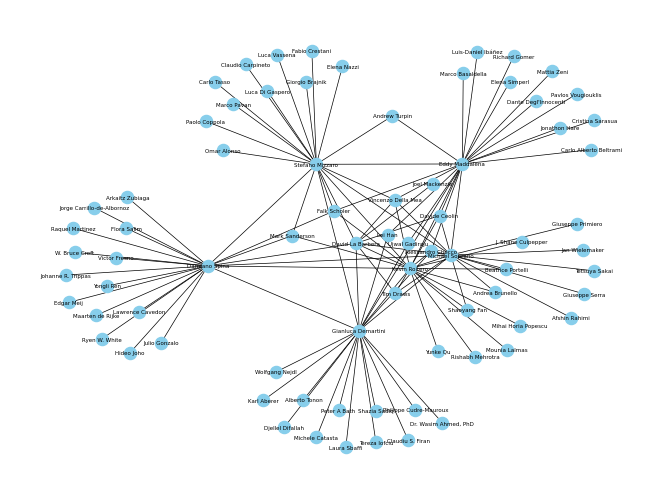

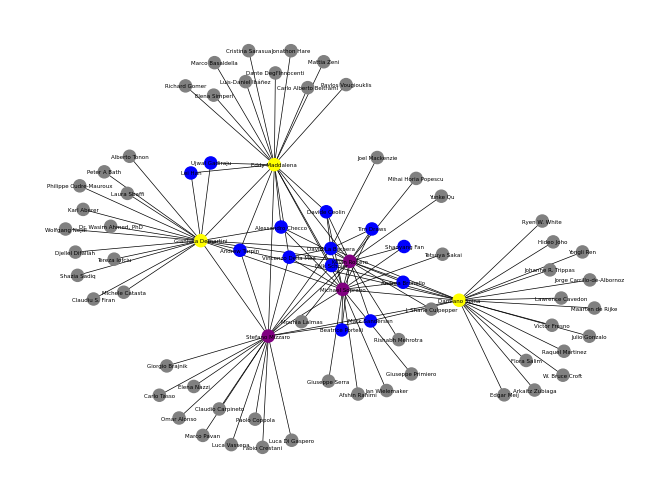

In [19]:
# 3. Utilizzando i due DataFrame prodotti:
# a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
# Salvare (serializzare) il grafo in locale nella cartella /graphs .
# b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
# seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con
# grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20,
# giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo
# visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella
# /visualizations.

def setNodecolorList(graph):
    # Calcolo del grado di ciascun nodo
    node_degrees = dict(graph.degree())
    
    # Definizione delle colorazioni in base al grado
    node_colors = []
    for node, degree in node_degrees.items():
        if degree == 1:
            node_colors.append('gray')
        elif 2 <= degree <= 10:
            node_colors.append('blue')
        elif 11 <= degree <= 20:
            node_colors.append('purple')
        else:
            node_colors.append('yellow')
            
    return node_colors

# Crea un grafo indiretto da DataFrame e aggiungo gli archi
grafo = nx.from_pandas_edgelist(df_edges, 'author1', 'author2', create_using=nx.Graph())

# Aggiunta dei nodi
for i, row in df_nodes.iterrows():
    grafo.add_node(row['name'], name=row['name'], affiliations=row['affiliations'], author_id=row['author_id'], cited_by=row['cited_by'], interests=row['interests'])

# Visualizzazione del grafo
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=grafo.number_of_nodes(), node_color='skyblue', font_size=4, width = 0.5)
plt.show()

# write_gpickle()
with open("graphs/coauthorship_graph.pkl", 'wb') as f:
    pickle.dump(grafo, f)

# Definizione delle colorazioni in base al grado
node_colors = setNodecolorList(grafo)

# Disegno del grafo
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=grafo.number_of_nodes(), node_color=node_colors, font_size=4, width = 0.5)

# Salvataggio del grafo
plt.savefig("visualizations/first_graph.pdf")

# Visualizzazione del grafo
plt.show()

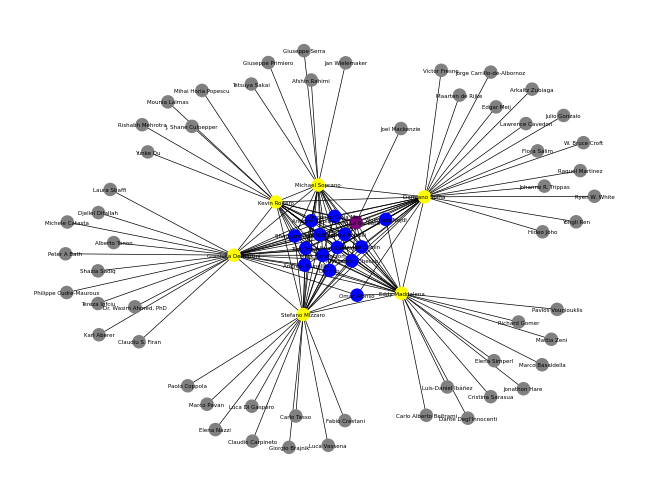

In [9]:
# 4. A partire dal grafo prodotto al punto 3:
# a. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di
# archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
# Salvare il grafo in locale nella cartella /graphs.
# b. Visualizzare e salvare il nuovo grafo come fatto al punto 3b

def setNodecolorList(graph):
    # Calcolo del grado di ciascun nodo
    node_degrees = dict(graph.degree())
    
    # Definizione delle colorazioni in base al grado
    node_colors = []
    for node, degree in node_degrees.items():
        if degree == 1:
            node_colors.append('gray')
        elif 2 <= degree <= 10:
            node_colors.append('blue')
        elif 11 <= degree <= 20:
            node_colors.append('purple')
        else:
            node_colors.append('yellow')
            
    return node_colors

def addNodepreferential_attachment(n):
    # Numero di archi da aggiungere
    additional_edges = n
    
    # Calcolo degli archi preferenziali da aggiungere con la funzione preferential_attachment
    pa_edges = list(nx.preferential_attachment(grafo))
    
    # Ordinamento degli archi in base al loro peso
    pa_edges.sort(key=lambda x: x[2], reverse=True)
    
    # Estrazione dei primi 'additional_edges' archi con maggiore peso
    selected_edges = pa_edges[:additional_edges]
    
    # Aggiunta degli archi al grafo esistente
    grafo.add_edges_from([(edge[0], edge[1]) for edge in selected_edges])

    return grafo
    
# Leggo grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    grafo = pickle.load(f)

grafo = addNodepreferential_attachment(50)

# Scrivo (serializzo) grafo
with open("graphs/extended_coauthorship_graph.pkl", 'wb') as f:
    pickle.dump(grafo, f)

node_colors = setNodecolorList(grafo)

# Disegno del grafo
pos = nx.spring_layout(grafo)  # Puoi cambiare l'algoritmo di layout se preferisci
nx.draw(grafo, pos, with_labels=True, node_size=grafo.number_of_nodes(), node_color=node_colors, font_size=4, width = 0.5)

# Salavataggio del grafo
plt.savefig("visualizations/extended_graph.pdf")

# Visualizzazione del grafo
plt.show()

In [16]:
# 5. Per entrambi i grafi prodotti calcolare:
# a. Coefficiente di clustering medio
# b. Centro del grafo
# c. Raggio
# d. Distanza Media
# e. Transitività
# f. Coefficienti Omega e Sigma, per stimare la “small-world-ness”
# g. Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le
# informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad
# una misura calcolata per quel grafo. Salvare nella cartella /results tale
# DataFrame.

def get_Info(grafo):
    new_row = {'coefficiente di clustering medio': nx.average_clustering(grafo), 'centro del grafo': nx.center(grafo), 'raggio': nx.radius(grafo), 'distanza media': nx.average_shortest_path_length(grafo), 'transitività': nx.transitivity(grafo), 'coefficiente omega': nx.omega(grafo), 'coefficiente sigma': nx.sigma(grafo)}
    return new_row

# Leggo grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    coauthorship_graph = pickle.load(f)

# Leggo grafo serializzato
with open("graphs/extended_coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    extended_coauthorship_graph = pickle.load(f)

# Ricavo le info relative ai due grafi e le inserisco nei dataframe opportuni
df_first_graph_centralities = pd.DataFrame(get_Info(coauthorship_graph))
df_extended_graph_centralities = pd.DataFrame(get_Info(extended_coauthorship_graph))

# Concateno i due dataframe
df_overall_measures = pd.concat([df_first_graph_centralities, df_extended_graph_centralities], ignore_index=True)

# Salvataggio del dataframe
df_overall_measures.to_csv("results/overall_measures.csv", index=False)

test1
1
2


KeyboardInterrupt: 

In [17]:
# 6. Per entrambi i grafi prodotti calcolare per ogni nodo:
# a. Degree Centrality
# b. Betweenness Centrality
# c. Closeness Centrality
# d. Pagerank
# e. HITS, per calcolare i valori di hubness e authority
# f. Riassumere le due informazioni in un DataFrame per ciascun grafo, dove
# ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le
# informazioni relative ad una misura calcolata per quel nodo. Salvare nella
# cartella /results tali DataFrame.

def get_graphInfo(grafo):
    #nodes = nx.nodes(coauthorship_graph)
    degree_centrality = nx.degree_centrality(grafo)
    betweenness_centrality = nx.betweenness_centrality(grafo)
    closeness_centrality = nx.closeness_centrality(grafo)
    pagerank = nx.pagerank(grafo)
    hits = nx.hits(grafo)

    # Creare un DataFrame
    df = pd.DataFrame({
        'Node': list(grafo.nodes()),
        'Degree Centrality': list(degree_centrality.values()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values()),
        'Pagerank': list(pagerank.values()),
        'HITS Hubness': list(hits[0].values()),
        'HITS Authority': list(hits[1].values())
    })
    return df

# Leggo grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    coauthorship_graph = pickle.load(f)

# Leggo grafo serializzato
with open("graphs/extended_coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    extended_coauthorship_graph = pickle.load(f)

# Ricavo le info relative ai due grafi e le inserisco nei dataframe opportuni
df_first_graph_centralities = pd.DataFrame(get_graphInfo(coauthorship_graph))
df_extended_graph_centralities = pd.DataFrame(get_graphInfo(extended_coauthorship_graph))

# Salvataggio dei dataframe
df_first_graph_centralities.to_csv("results/first_graph_centralities.csv", index=False)
df_extended_graph_centralities.to_csv("results/extended_graph_centralities.csv", index=False)

In [18]:
# 7. Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di
# nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella
# /visualizations .

def setNodecolorDict(graph):
    node_degrees = dict(graph.degree())
    node_colors_options = {}
    i = 1

    # Imposta colore dei nodi in base al grado
    for node, degree in node_degrees.items():
        if degree == 1:
            node_colors_options[i-1] = {'color': 'gray'}
        elif 2 <= degree <= 10:
            node_colors_options[i-1] = {'color': 'blue'}
        elif 11 <= degree <= 20:
            node_colors_options[i-1] = {'color': 'purple'}
        else:
            node_colors_options[i-1] = {'color': 'yellow'}
        i += 1
    
    # Aggiorna le opzioni del colore dei nodi
    for i, options in node_colors_options.items():
        nt.nodes[i].update(options)

    return nt
    
# Leggo grafo serializzato
with open("graphs/coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    coauthorship_graph = pickle.load(f)

# Leggo grafo serializzato
with open("graphs/extended_coauthorship_graph.pkl", 'rb') as f:  # notice the r instead of w
    extended_coauthorship_graph = pickle.load(f)

nt = Network('1000px', '1000px')

# Creazione e salvataggio primo grafo interattivo
nt.from_nx(coauthorship_graph)
nt = setNodecolorDict(coauthorship_graph)
nt.save_graph("visualizations/interactive_first_graphs.html")

# Creazione e salvataggio grafo esteso interattivo
nt.from_nx(extended_coauthorship_graph)
nt = setNodecolorDict(coauthorship_graph)
nt.save_graph("visualizations/interactive_extended_graphs.html")